# Đồ án MXH – Community Detection & Link Prediction (Năm 2022)

## 1 – Imports & cấu hình cơ bản

In [87]:
# Imports & cấu hình cơ bản

import numpy as np
import pandas as pd
import networkx as nx
import random

from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Đặt seed cho reproducibility
random.seed(42)
np.random.seed(42)

## 2 - Đọc dữ liệu

In [2]:
DATA_PATH = r"dblp.xml\dblp.csv"

# 1) Đọc dữ liệu
df = pd.read_csv(DATA_PATH, low_memory=False)

# 2) Chuyển mdate sang datetime -> year
df['year'] = pd.to_datetime(df['mdate'], errors='coerce').dt.year

# 3) Lọc chỉ năm 2021–2023
df_2021_2023 = df[(df['year'] >= 2021) & (df['year'] <= 2023)].copy()
print("Số dòng (bài báo) 2021–2023 (trước khi xử lý tác giả):", len(df_2021_2023))

# 4) Đảm bảo có cột authors_list (list các tác giả trong mỗi bài)
#    Giả sử cột 'authors_str' là chuỗi tác giả ngăn cách bởi '||' hoặc ';' hoặc ','
if 'authors_list' not in df_2021_2023.columns:
    def split_authors(x):
        if pd.isna(x):
            return []
        s = str(x)
        if '||' in s:
            parts = s.split('||')
        elif ';' in s:
            parts = s.split(';')
        else:
            parts = s.split(',')  # fallback
        return [a.strip() for a in parts if a.strip()]

    df_2021_2023['authors_list'] = df_2021_2023['authors_str'].apply(split_authors)

# 5) Hàm clean tên tác giả:
#    - Bỏ rỗng
#    - Bỏ tất cả tên KHÔNG có dấu cách (vd: "M", "G", "Li", "Zhang", "CL", ...)
def clean_author_name(name):
    s = str(name).strip()
    if not s:
        return None
    
    # Bỏ mọi tên không có dấu cách
    # Chỉ giữ tên có ít nhất 1 space, ví dụ: "Jing Su", "M. Zhang", "A B"
    if ' ' not in s:
        return None
    
    return s

def clean_authors_list(lst):
    cleaned = []
    for a in lst:
        if not isinstance(a, str):
            continue
        s = clean_author_name(a)
        if s is not None:
            cleaned.append(s)
    return cleaned

# 6) Áp dụng clean
df_2021_2023['authors_list'] = df_2021_2023['authors_list'].apply(clean_authors_list)

# 7) Giữ lại các bài có ít nhất 2 tác giả sau khi clean
df_2021_2023 = df_2021_2023[df_2021_2023['authors_list'].str.len() >= 2].copy()

print("Sau khi clean (xoá tên không có dấu cách) & bỏ bài < 2 tác giả:", len(df_2021_2023))
df_2021_2023[['title', 'year', 'authors_list']].head()

Số dòng (bài báo) 2021–2023 (trước khi xử lý tác giả): 755318
Sau khi clean (xoá tên không có dấu cách) & bỏ bài < 2 tác giả: 691747


,title,year,authors_list
18,Timed Automata for Video Games and Interaction.,2023,"[Jaime Arias 0001, Myriam Desainte-Catherine]"
41,"Mixed Reality, Gamified Presence, and Storytel...",2022,"[George Papagiannakis, Efstratios Geronikolaki..."
47,Biosensing in Interactive Art: A User-Centered...,2022,"[Rui Penha, Gilberto Bernardes]"
60,"Key Early Verticals, Challenges and Limitation...",2021,"[Adnan Mahmood, Bernard Butler, Hushairi Zen, ..."
75,Everyday Virtual Reality.,2021,"[Tom Alexander Garner, Wendy A. Powell, Vaugha..."


## 3 – Xây graph đồng tác giả

In [3]:
# Cell X – Build edges cho từng năm & G_full

def get_edges_from_authors(authors_list):
    authors_unique = list(dict.fromkeys(authors_list))
    edges = set()
    n = len(authors_unique)
    for i in range(n):
        for j in range(i + 1, n):
            u = authors_unique[i]
            v = authors_unique[j]
            if u == v:
                continue
            if u > v:
                u, v = v, u
            edges.add((u, v))
    return edges

edges_by_year = {2021: set(), 2022: set(), 2023: set()}

for _, row in df_2021_2023.iterrows():
    y = int(row['year'])
    if y not in edges_by_year:
        continue
    e_set = get_edges_from_authors(row['authors_list'])
    edges_by_year[y].update(e_set)

for y in sorted(edges_by_year.keys()):
    print(f"Năm {y}: số cạnh =", len(edges_by_year[y]))

# G_full: tất cả cạnh 2021–2023
all_edges_2021_2023 = set().union(*edges_by_year.values())
G_full = nx.Graph()
G_full.add_edges_from(all_edges_2021_2023)

print("\nG_full (2021–2023) |V| =", G_full.number_of_nodes(), "|E| =", G_full.number_of_edges())

Năm 2021: số cạnh = 1780578
Năm 2022: số cạnh = 3308721
Năm 2023: số cạnh = 744189

G_full (2021–2023) |V| = 947578 |E| = 5264400


## 4 - Network Characteristics

In [4]:
# Thống kê cơ bản & giant component

num_nodes = G_full.number_of_nodes()
num_edges = G_full.number_of_edges()
density   = nx.density(G_full)

print(f"G_full |V| = {num_nodes}, |E| = {num_edges}")
print(f"Density = {density:.6f}")

# Degree stats
degree_list = [d for _, d in G_full.degree()]
print("\nDegree statistics:")
print("  min   =", int(np.min(degree_list)) if degree_list else 0)
print("  max   =", int(np.max(degree_list)) if degree_list else 0)
print("  mean  =", float(np.mean(degree_list)) if degree_list else 0.0)
print("  median=", float(np.median(degree_list)) if degree_list else 0.0)

# Giant component (nếu graph rời rạc)
components = list(nx.connected_components(G_full))
giant = max(components, key=len)
G_gc = G_full.subgraph(giant).copy()
print("\nGiant component: |V| =", G_gc.number_of_nodes(), "|E| =", G_gc.number_of_edges())

# Average clustering
try:
    avg_clustering = nx.average_clustering(G_gc)
    print("Average clustering (GC) =", avg_clustering)
except Exception as e:
    print("Average clustering (GC) – lỗi:", e)

# Approx average shortest path & diameter
try:
    MAX_SAMPLE_NODES = 3000  # có thể tăng/giảm tuỳ máy

    nodes_gc = list(G_gc.nodes())
    start = random.choice(nodes_gc)

    # BFS mở rộng từ 1 node để đảm bảo subgraph liên thông
    visited = {start}
    queue = [start]

    while queue and len(visited) < MAX_SAMPLE_NODES:
        u = queue.pop(0)
        for v in G_gc.neighbors(u):
            if v not in visited:
                visited.add(v)
                queue.append(v)
                if len(visited) >= MAX_SAMPLE_NODES:
                    break

    G_sample = G_gc.subgraph(visited).copy()
    print(f"Using BFS-sampled connected subgraph with {G_sample.number_of_nodes()} nodes "
          f"and {G_sample.number_of_edges()} edges for ASP & diameter.")

    asp_sample = nx.average_shortest_path_length(G_sample)
    diam_sample = nx.diameter(G_sample)

    print("Approx average shortest path (GC, via BFS sample) =", asp_sample)
    print("Approx diameter (GC, via BFS sample) =", diam_sample)

except Exception as e:
    print("Approx path length / diameter – lỗi:", e)

G_full |V| = 947578, |E| = 5264400
Density = 0.000012

Degree statistics:
  min   = 1
  max   = 2379
  mean  = 11.111275272325866
  median= 5.0

Giant component: |V| = 824735 |E| = 5074573
Average clustering (GC) = 0.7269056068151332
Using BFS-sampled connected subgraph with 3000 nodes and 27409 edges for ASP & diameter.
Approx average shortest path (GC, via BFS sample) = 2.7087431366010892
Approx diameter (GC, via BFS sample) = 8


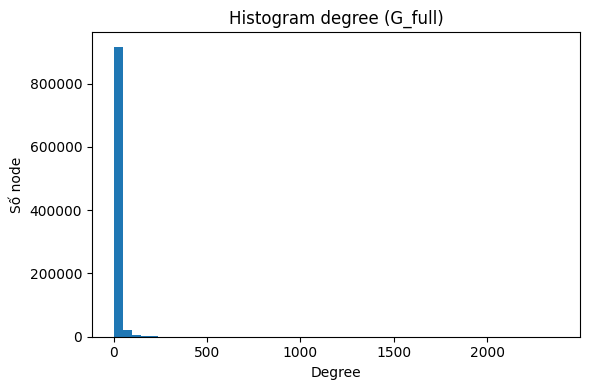

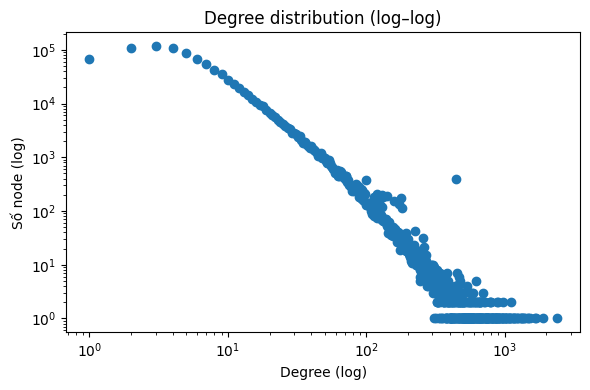

In [5]:
# Histogram degree distribution cho G_full

import matplotlib.pyplot as plt

degrees = [d for _, d in G_full.degree()]

plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Số node")
plt.title("Histogram degree (G_full)")
plt.tight_layout()
plt.show()

# Log–log plot (degree vs count)
deg_counts = pd.Series(degrees).value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.scatter(deg_counts.index, deg_counts.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log)")
plt.ylabel("Số node (log)")
plt.title("Degree distribution (log–log)")
plt.tight_layout()
plt.show()

## 5 – Centrality & Key players

In [6]:
# Degree & PageRank cho G_full

deg_dict = dict(G_full.degree())
top_deg = sorted(deg_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 tác giả theo degree:")
for n, d in top_deg:
    print(f"  {n} – degree = {d}")

try:
    pr = nx.pagerank(G_full, alpha=0.85)
    top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 tác giả theo PageRank:")
    for n, s in top_pr:
        print(f"  {n} – PageRank = {s:.6e}")
except Exception as e:
    print("PageRank – lỗi / quá chậm:", e)


Top 10 tác giả theo degree:
  Yang Liu – degree = 2379
  Wei Wang – degree = 1900
  Wei Zhang – degree = 1698
  Yu Zhang – degree = 1671
  Hao Wang – degree = 1537
  Wei Liu – degree = 1479
  Xin Li – degree = 1476
  Lei Wang – degree = 1400
  Xin Wang – degree = 1391
  Wei Li – degree = 1349

Top 10 tác giả theo PageRank:
  Yang Liu – PageRank = 1.443245e-04
  Wei Wang – PageRank = 1.288356e-04
  Yu Zhang – PageRank = 1.063598e-04
  Wei Zhang – PageRank = 1.020982e-04
  Hao Wang – PageRank = 9.232262e-05
  Lei Wang – PageRank = 8.782909e-05
  Xin Wang – PageRank = 8.214135e-05
  Wei Liu – PageRank = 8.154973e-05
  Yang Li – PageRank = 8.144327e-05
  Yi Zhang – PageRank = 8.064252e-05


## 6 – Tạo train/val/test từ cạnh năm 2022

In [7]:
# Cell Y – Temporal split: Train (2020–2021), Val (2022), Test (2023)

train_years = [2021]
val_years   = [2022]
test_years  = [2023]

edges_train = set().union(*(edges_by_year[y] for y in train_years))
edges_val_candidates  = set().union(*(edges_by_year[y] for y in val_years))
edges_test_candidates = set().union(*(edges_by_year[y] for y in test_years))

# Chỉ giữ cạnh xuất hiện lần đầu ở giai đoạn đó
edges_val  = edges_val_candidates  - edges_train
edges_test = edges_test_candidates - edges_train - edges_val

print("Train edges (2021):", len(edges_train))
print("Val edges (new in 2022):", len(edges_val))
print("Test edges (new in 2023):", len(edges_test))

# Xây G_train từ edges_train
G_train = nx.Graph()
G_train.add_nodes_from(G_full.nodes())
G_train.add_edges_from(edges_train)

print("G_train |V| =", G_train.number_of_nodes(), "|E| =", G_train.number_of_edges())

Train edges (2021): 1780578
Val edges (new in 2022): 2929875
Test edges (new in 2023): 553947
G_train |V| = 947578 |E| = 1780578


## 7 – Community detection: Louvain + Label Propagation

In [8]:
# Louvain & Label Propagation trên G_train

from networkx.algorithms.community import louvain_communities, asyn_lpa_communities

print("Running Louvain on G_train...")
louvain_comms = louvain_communities(G_train, seed=42, resolution=1.0)
node2comm_louvain = {}
for cid, comm_nodes in enumerate(louvain_comms):
    for n in comm_nodes:
        node2comm_louvain[n] = cid

louvain_sizes = [len(c) for c in louvain_comms]
print("Louvain communities:", len(louvain_comms))
print("  size min =", min(louvain_sizes),
      "max =", max(louvain_sizes),
      "mean =", float(np.mean(louvain_sizes)))

print("\nRunning Label Propagation (LPA) on G_train...")
lpa_comms = list(asyn_lpa_communities(G_train, seed=42))
node2comm_lpa = {}
for cid, comm_nodes in enumerate(lpa_comms):
    for n in comm_nodes:
        node2comm_lpa[n] = cid

lpa_sizes = [len(c) for c in lpa_comms]
print("LPA communities:", len(lpa_comms))
print("  size min =", min(lpa_sizes),
      "max =", max(lpa_sizes),
      "mean =", float(np.mean(lpa_sizes)))

Running Louvain on G_train...
Louvain communities: 490088
  size min = 1 max = 16659 mean = 1.9334854148642693

Running Label Propagation (LPA) on G_train...
LPA communities: 547053
  size min = 1 max = 214 mean = 1.7321502669759603


## 8 – Hàm sinh community features cho cặp (u, v)

In [9]:
# Hàm community features

def compute_community_features(u, v):
    # Louvain
    clu = node2comm_louvain.get(u, -1)
    clv = node2comm_louvain.get(v, -1)
    same_louvain = int(clu != -1 and clv != -1 and clu == clv)
    
    # Label Propagation
    plu = node2comm_lpa.get(u, -1)
    plv = node2comm_lpa.get(v, -1)
    same_lpa = int(plu != -1 and plv != -1 and plu == plv)
    
    both_has_comm = int(
        clu != -1 and clv != -1 and
        plu != -1 and plv != -1
    )
    same_comm_both = int(same_louvain == 1 and same_lpa == 1)
    
    return {
        'same_comm_louvain': same_louvain,
        'same_comm_lpa': same_lpa,
        'same_comm_both': same_comm_both,
        'both_has_comm': both_has_comm,
        'comm_louv_u': clu,
        'comm_louv_v': clv,
        'comm_lpa_u': plu,
        'comm_lpa_v': plv,
    }

## 9 – Centrality cho link prediction

In [10]:
# Tính centrality (degree + PageRank) & hàm centrality features

# Degree từ G_train
deg_all = dict(G_train.degree())

# PageRank trên G_train (tương đối nhanh hơn closeness rất nhiều)
try:
    pr_all = nx.pagerank(G_train, alpha=0.85)
except Exception as e:
    print("PageRank (G_train) lỗi, set mặc định 0.0:", e)
    from collections import defaultdict
    pr_all = defaultdict(float)

# Đảm bảo pr_all là defaultdict để get không lỗi
from collections import defaultdict
if not isinstance(pr_all, defaultdict):
    tmp = defaultdict(float)
    tmp.update(pr_all)
    pr_all = tmp

def compute_centrality_features(u, v):
    du = deg_all.get(u, 0)
    dv = deg_all.get(v, 0)

    pru = pr_all[u]
    prv = pr_all[v]

    return {
        'deg_u': du,
        'deg_v': dv,
        'deg_sum': du + dv,
        'deg_diff': abs(du - dv),
        'pr_u': pru,
        'pr_v': prv,
        'pr_sum': pru + prv,
        'pr_diff': abs(pru - prv),
    }

## 10 – Heuristic similarity cho cặp (u, v)

In [11]:
# Heuristic similarity trên G_train

neighbors = {n: set(G_train.neighbors(n)) for n in G_train.nodes()}
degrees_train = dict(G_train.degree())

def compute_heuristics(u, v):
    nu = neighbors.get(u)
    nv = neighbors.get(v)
    if nu is None:
        nu = set(G_train.neighbors(u))
        neighbors[u] = nu
    if nv is None:
        nv = set(G_train.neighbors(v))
        neighbors[v] = nv
    
    cn = len(nu & nv)
    union = nu | nv
    jaccard = cn / len(union) if union else 0.0
    
    # Adamic–Adar
    aa = 0.0
    for w in nu & nv:
        dw = degrees_train.get(w)
        if dw is None:
            dw = G_train.degree(w)
            degrees_train[w] = dw
        if dw > 1:
            aa += 1.0 / np.log(dw)
    
    # Resource Allocation
    ra = 0.0
    for w in nu & nv:
        dw = degrees_train.get(w)
        if dw is None:
            dw = G_train.degree(w)
            degrees_train[w] = dw
        if dw > 0:
            ra += 1.0 / dw
    
    # Preferential Attachment
    du = degrees_train.get(u)
    if du is None:
        du = G_train.degree(u)
        degrees_train[u] = du
    dv = degrees_train.get(v)
    if dv is None:
        dv = G_train.degree(v)
        degrees_train[v] = dv
    
    pa = du * dv
    
    return {
        'cn': cn,
        'jaccard': jaccard,
        'aa': aa,
        'ra': ra,
        'pa': pa,
    }


## 11 – Positive/Negative edges cho val & test

In [12]:
# Sinh positive/negative edges cho val & test

def sample_set(s, max_size):
    if len(s) <= max_size:
        return set(s)
    return set(random.sample(list(s), max_size))

# Positive edges
positive_val_full  = edges_val
positive_test_full = edges_test

positive_val_sample  = positive_val_full   # = edges_val
positive_test_sample = positive_test_full  # = edges_test

print("Positive_val_sample :", len(positive_val_sample))
print("Positive_test_sample:", len(positive_test_sample))

# Hàm lấy negative edges
all_nodes = list(G_train.nodes())
all_edges_set = set(G_full.edges())  # tất cả cạnh có thật trong năm 2022 (full graph)

def sample_negative_edges(num_samples):
    neg = set()
    attempts = 0
    max_attempts = num_samples * 20
    
    while len(neg) < num_samples and attempts < max_attempts:
        u, v = random.sample(all_nodes, 2)
        if u > v:
            u, v = v, u
        attempts += 1
        
        if (u, v) in all_edges_set:
            continue
        
        neg.add((u, v))
    
    return neg

negative_val  = sample_negative_edges(len(positive_val_sample))
negative_test = sample_negative_edges(len(positive_test_sample))

print("Negative_val :", len(negative_val))
print("Negative_test:", len(negative_test))

Positive_val_sample : 2929875
Positive_test_sample: 553947
Negative_val : 2929875
Negative_test: 553947


## 12 – Build DataFrame feature (Heuristic + Community + Centrality)

In [13]:
# Build edges_val_df & edges_test_df

def build_edge_feature_df(positive_edges, negative_edges):
    rows = []
    
    # Positive edges
    for (u, v) in positive_edges:
        feats = {}
        feats.update(compute_heuristics(u, v))
        feats.update(compute_community_features(u, v))
        feats.update(compute_centrality_features(u, v))
        feats['u'] = u
        feats['v'] = v
        feats['label'] = 1
        rows.append(feats)
    
    # Negative edges
    for (u, v) in negative_edges:
        feats = {}
        feats.update(compute_heuristics(u, v))
        feats.update(compute_community_features(u, v))
        feats.update(compute_centrality_features(u, v))
        feats['u'] = u
        feats['v'] = v
        feats['label'] = 0
        rows.append(feats)
    
    return pd.DataFrame(rows)

edges_val_df  = build_edge_feature_df(positive_val_sample,  negative_val)
edges_test_df = build_edge_feature_df(positive_test_sample, negative_test)

print(edges_val_df.head())
print("\nVal label counts:")
print(edges_val_df['label'].value_counts())
print("\nTest label counts:")
print(edges_test_df['label'].value_counts())

   cn  jaccard   aa   ra  pa  same_comm_louvain  same_comm_lpa  \
0   0      0.0  0.0  0.0   0                  0              0   
1   0      0.0  0.0  0.0   0                  0              0   
2   0      0.0  0.0  0.0   0                  0              0   
3   0      0.0  0.0  0.0   0                  0              0   
4   0      0.0  0.0  0.0   0                  0              0   

   same_comm_both  both_has_comm  comm_louv_u  ...  deg_v  deg_sum  deg_diff  \
0               0              1        22293  ...      0        0         0   
1               0              1            0  ...      0        0         0   
2               0              1       313319  ...      0        2         2   
3               0              1        16046  ...      0        0         0   
4               0              1       128686  ...      0       18        18   

           pr_u          pr_v    pr_sum       pr_diff                    u  \
0  5.933697e-07  5.933697e-07  0.000001  0.0

## 13 – Logistic Regression: Heuristic-only (baseline)

In [14]:
# Logistic Regression baseline (Heuristic-only)

feature_cols_heur = ['cn', 'jaccard', 'aa', 'ra', 'pa']

X_train_heur = edges_val_df[feature_cols_heur].values
y_train      = edges_val_df['label'].values

X_test_heur  = edges_test_df[feature_cols_heur].values
y_test       = edges_test_df['label'].values

clf_heur = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

clf_heur.fit(X_train_heur, y_train)

y_scores_heur = clf_heur.predict_proba(X_test_heur)[:, 1]
auc_heur = roc_auc_score(y_test, y_scores_heur)
ap_heur  = average_precision_score(y_test, y_scores_heur)

print("LOGISTIC – Heuristic-only")
print("  AUC:", auc_heur)
print("  AP :", ap_heur)


LOGISTIC – Heuristic-only
  AUC: 0.5191028115244696
  AP : 0.5981796119230413


## 14 – Logistic Regression: Heuristic + Community + Centrality

In [15]:
# Logistic Regression với Heuristic + Community + Centrality (degree + PageRank)

feature_cols_full = [
    # Heuristic
    'cn', 'jaccard', 'aa', 'ra', 'pa',
    # Community
    'same_comm_louvain', 'same_comm_lpa', 'same_comm_both', 'both_has_comm',
    # Centrality: degree + PageRank
    'deg_u', 'deg_v', 'deg_sum', 'deg_diff',
    'pr_u', 'pr_v', 'pr_sum', 'pr_diff',
]

X_train_full = edges_val_df[feature_cols_full].values
X_test_full  = edges_test_df[feature_cols_full].values

clf_full = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

clf_full.fit(X_train_full, y_train)

y_scores_full = clf_full.predict_proba(X_test_full)[:, 1]
auc_full = roc_auc_score(y_test, y_scores_full)
ap_full  = average_precision_score(y_test, y_scores_full)

print("LOGISTIC – Heuristic + Community + Centrality (deg + PR)")
print("  AUC:", auc_full)
print("  AP :", ap_full)

print("\nSo sánh với baseline:")
print("  Heuristic-only                  AUC:", auc_heur, "AP:", ap_heur)
print("  Heur+Comm+Centrality (deg+PR)   AUC:", auc_full, "AP:", ap_full)

LOGISTIC – Heuristic + Community + Centrality (deg + PR)
  AUC: 0.634683045104576
  AP : 0.7073727253149147

So sánh với baseline:
  Heuristic-only                  AUC: 0.5191028115244696 AP: 0.5981796119230413
  Heur+Comm+Centrality (deg+PR)   AUC: 0.634683045104576 AP: 0.7073727253149147


## 15 – Random Forest: Heuristic + Community + Centrality

In [16]:
# Random Forest với Heuristic + Community + Centrality (deg + PR),
# cấu hình tiết kiệm RAM hơn

rf = RandomForestClassifier(
    n_estimators=100,              # giảm số cây từ 200 -> 100
    max_depth=15,                 # giới hạn độ sâu cây (tránh cây quá sâu)
    min_samples_split=5,          # không cho split quá chi tiết
    min_samples_leaf=10,          # mỗi lá phải có ít nhất 10 mẫu
    max_features='sqrt',          # mỗi node chỉ xem 1 phần feature
    n_jobs=1,                     # dùng 1 core để tránh nhân bản dữ liệu ở nhiều process
    class_weight='balanced_subsample',
    random_state=42,
    max_samples=0.5,              # mỗi cây chỉ train trên 50% mẫu (subsample)
)

rf.fit(X_train_full, y_train)

y_scores_rf = rf.predict_proba(X_test_full)[:, 1]
auc_rf = roc_auc_score(y_test, y_scores_rf)
ap_rf  = average_precision_score(y_test, y_scores_rf)

print("RANDOM FOREST – Heuristic + Community + Centrality (deg + PR) [RAM-friendly]")
print("  AUC:", auc_rf)
print("  AP :", ap_rf)

print("\nSo sánh tất cả model:")
print("  Logistic (Heur-only)                  AUC:", auc_heur, "AP:", ap_heur)
print("  Logistic (Heur+Comm+Centrality)       AUC:", auc_full, "AP:", ap_full)
print("  RandomForest (Heur+Comm+Centrality)   AUC:", auc_rf,  "AP:", ap_rf)

RANDOM FOREST – Heuristic + Community + Centrality (deg + PR) [RAM-friendly]
  AUC: 0.7691232936742639
  AP : 0.7643141694408551

So sánh tất cả model:
  Logistic (Heur-only)                  AUC: 0.5191028115244696 AP: 0.5981796119230413
  Logistic (Heur+Comm+Centrality)       AUC: 0.634683045104576 AP: 0.7073727253149147
  RandomForest (Heur+Comm+Centrality)   AUC: 0.7691232936742639 AP: 0.7643141694408551


## 16 – Precision@K cho 3 model

In [88]:
def print_clf_metrics(y_true, y_score, name, threshold=0.5):
    y_pred = (y_score >= threshold).astype(int)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    print(f"=== {name} (threshold = {threshold}) ===")
    print(f"  Precision = {prec:.4f}")
    print(f"  Recall    = {rec:.4f}")
    print(f"  F1-score  = {f1:.4f}")
    print()

y_test_np = y_test if isinstance(y_test, np.ndarray) else np.asarray(y_test)

print_clf_metrics(y_test_np, y_scores_heur, "Logistic – Heuristic-only")
print_clf_metrics(y_test_np, y_scores_full, "Logistic – Heur+Comm+Cent")
print_clf_metrics(y_test_np, y_scores_rf,   "Random Forest – Heur+Comm+Cent")

=== Logistic – Heuristic-only (threshold = 0.5) ===
  Precision = 0.7629
  Recall    = 0.2064
  F1-score  = 0.3249

=== Logistic – Heur+Comm+Cent (threshold = 0.5) ===
  Precision = 0.7761
  Recall    = 0.3886
  F1-score  = 0.5179

=== Random Forest – Heur+Comm+Cent (threshold = 0.5) ===
  Precision = 0.6797
  Recall    = 0.7604
  F1-score  = 0.7178



In [89]:
def precision_at_k(y_true, y_score, k):
    assert len(y_true) == len(y_score)
    k = min(k, len(y_true))
    order = np.argsort(-y_score)
    topk_idx = order[:k]
    topk_true = y_true[topk_idx]
    return topk_true.sum() / k

def recall_at_k(y_true, y_score, k):
    assert len(y_true) == len(y_score)
    k = min(k, len(y_true))
    order = np.argsort(-y_score)
    topk_idx = order[:k]
    topk_true = y_true[topk_idx]
    tp = topk_true.sum()
    total_pos = y_true.sum()
    if total_pos == 0:
        return 0.0
    return tp / total_pos

def f1_at_k(y_true, y_score, k):
    p = precision_at_k(y_true, y_score, k)
    r = recall_at_k(y_true, y_score, k)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

y_test_np = y_test if isinstance(y_test, np.ndarray) else np.asarray(y_test)

for K in [50, 100, 500, 1000]:
    p_heur = precision_at_k(y_test_np, y_scores_heur, K)
    r_heur = recall_at_k(y_test_np,    y_scores_heur, K)
    f_heur = f1_at_k(y_test_np,        y_scores_heur, K)

    p_full = precision_at_k(y_test_np, y_scores_full, K)
    r_full = recall_at_k(y_test_np,    y_scores_full, K)
    f_full = f1_at_k(y_test_np,        y_scores_full, K)

    p_rf   = precision_at_k(y_test_np, y_scores_rf, K)
    r_rf   = recall_at_k(y_test_np,    y_scores_rf, K)
    f_rf   = f1_at_k(y_test_np,        y_scores_rf, K)

    print(f"=== K = {K} ===")
    print(f"Logistic (Heur-only):")
    print(f"  P@K = {p_heur:.4f}, R@K = {r_heur:.4f}, F1@K = {f_heur:.4f}")
    print(f"Logistic (Heur+Comm+Cent):")
    print(f"  P@K = {p_full:.4f}, R@K = {r_full:.4f}, F1@K = {f_full:.4f}")
    print(f"Random Forest (Heur+Comm+Cent):")
    print(f"  P@K = {p_rf:.4f}, R@K = {r_rf:.4f}, F1@K = {f_rf:.4f}")
    print()

=== K = 50 ===
Logistic (Heur-only):
  P@K = 1.0000, R@K = 0.0001, F1@K = 0.0002
Logistic (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0001, F1@K = 0.0002
Random Forest (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0001, F1@K = 0.0002

=== K = 100 ===
Logistic (Heur-only):
  P@K = 1.0000, R@K = 0.0002, F1@K = 0.0004
Logistic (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0002, F1@K = 0.0004
Random Forest (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0002, F1@K = 0.0004

=== K = 500 ===
Logistic (Heur-only):
  P@K = 1.0000, R@K = 0.0009, F1@K = 0.0018
Logistic (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0009, F1@K = 0.0018
Random Forest (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0009, F1@K = 0.0018

=== K = 1000 ===
Logistic (Heur-only):
  P@K = 1.0000, R@K = 0.0018, F1@K = 0.0036
Logistic (Heur+Comm+Cent):
  P@K = 0.9980, R@K = 0.0018, F1@K = 0.0036
Random Forest (Heur+Comm+Cent):
  P@K = 1.0000, R@K = 0.0018, F1@K = 0.0036



## Hàm gợi ý top-K đồng tác giả cho 1 tác giả

In [92]:
def evaluate_author_topk_local(
    author_name,
    K=10,
    model='full',
    use_future='test',
    use_louvain_filter=True,
    max_2hop=True
):
    # 1) Kiểm tra author
    if author_name not in G_train:
        print(f"Tác giả '{author_name}' không nằm trong G_train.")
        return None, None, None
    
    # 2) Chọn map tương lai
    if use_future == 'test':
        fut_map = future_neighbors_test
        fut_label = "test (2023)"
    elif use_future == 'val':
        fut_map = future_neighbors_val
        fut_label = "val (2022)"
    else:
        print("use_future phải là 'test' hoặc 'val'")
        return None, None, None
    
    true_future = fut_map[author_name]
    if len(true_future) == 0:
        print(f"Tác giả '{author_name}' không có co-author mới trong {fut_label}.")
        return None, None, None
    
    # 3) Chọn model + feature
    if model == 'full':
        # DÙNG RANDOM FOREST VỚI FULL FEATURES
        clf = rf
        feat_cols = feature_cols_full
        model_name = "Random Forest (Heur+Comm+Centrality)"
    elif model == 'heur':
        # Logistic baseline với heuristic-only
        clf = clf_heur
        feat_cols = ['cn', 'jaccard', 'aa', 'ra', 'pa']
        model_name = "Logistic (Heuristic-only)"
    else:
        print("model phải là 'full' hoặc 'heur'")
        return None, None, None
    
    # 4) Co-author cũ trong G_train
    old_neighbors = set(G_train.neighbors(author_name))
    old_neighbors.add(author_name)
    
    # 5) Sinh candidate
    if max_2hop:
        two_hop = set()
        for nb in G_train.neighbors(author_name):
            two_hop.update(G_train.neighbors(nb))
        candidates = two_hop
    else:
        candidates = set(G_train.nodes())
    
    # Loại co-author cũ + self
    candidates = candidates - old_neighbors
    
    # Optional: lọc theo cùng Louvain community
    if use_louvain_filter:
        comm_u = node2comm_louvain.get(author_name, -1)
        candidates = {
            v for v in candidates
            if node2comm_louvain.get(v, -2) == comm_u
        }
    
    if not candidates:
        print(f"Tác giả '{author_name}' không có candidate nào (2-hop/community quá hẹp).")
        return None, None, None
    
    # 6) Tính feature cho từng (u, v)
    rows = []
    for v in candidates:
        u, w = author_name, v
        feats = {}
        feats.update(compute_heuristics(u, w))
        feats.update(compute_community_features(u, w))
        feats.update(compute_centrality_features(u, w))
        feats['candidate'] = w
        rows.append(feats)
    
    df_cand = pd.DataFrame(rows)
    
    # 7) Chuẩn bị X và tính score
    X_cand = df_cand[feat_cols].values
    scores = clf.predict_proba(X_cand)[:, 1]
    df_cand['score'] = scores
    
    # 8) Sort & top-K
    df_topk = df_cand.sort_values('score', ascending=False).head(K).copy()
    rec_set = set(df_topk['candidate'].tolist())
    
    # 9) Metrics
    hits = rec_set & true_future
    num_hits = len(hits)
    num_true = len(true_future)
    hit_k = 1 if num_hits > 0 else 0
    precision_k = num_hits / K
    recall_k = num_hits / num_true if num_true > 0 else 0.0
    
    # 10) In kết quả
    print(f"Tác giả: {author_name}")
    print(f"  Số co-author mới trong {fut_label}: {num_true}")
    print(f"  Model: {model_name}")
    print(f"  Candidate: 2-hop = {max_2hop}, Louvain filter = {use_louvain_filter}")
    print(f"  K = {K}")
    print(f"  Hit@K      = {hit_k}   (1 nếu có ít nhất 1 co-author tương lai trong top-K)")
    print(f"  Precision@K= {precision_k:.4f}")
    print(f"  Recall@K   = {recall_k:.4f}")
    print(f"  Hits ({num_hits}):", hits)
    
    cols_to_show = [c for c in [
        'candidate', 'score',
        'cn', 'jaccard', 'aa', 'ra', 'pa',
        'same_comm_louvain', 'same_comm_lpa',
        'deg_u', 'deg_v'
    ] if c in df_topk.columns]
    print("\nTop-K gợi ý (một số feature chính):")
    display(df_topk[cols_to_show])
    
    metrics = {
        'author': author_name,
        'K': K,
        'Hit@K': hit_k,
        'Precision@K': precision_k,
        'Recall@K': recall_k,
        'num_true_future': num_true,
        'num_hits': num_hits,
        'model': model_name,
        'use_future': fut_label,
        'use_louvain_filter': use_louvain_filter,
        'max_2hop': max_2hop,
    }
    return metrics, df_topk, hits

metrics, df_topk, hits = evaluate_author_topk_local(
    author_name="Dheevatsa Mudigere",
    K=20,
    model='full',
    use_future='test',
    use_louvain_filter=True,
    max_2hop=True
)
metrics

Tác giả: Dheevatsa Mudigere
  Số co-author mới trong test (2023): 14
  Model: Random Forest (Heur+Comm+Centrality)
  Candidate: 2-hop = True, Louvain filter = True
  K = 20
  Hit@K      = 0   (1 nếu có ít nhất 1 co-author tương lai trong top-K)
  Precision@K= 0.0000
  Recall@K   = 0.0000
  Hits (0): set()

Top-K gợi ý (một số feature chính):


,candidate,score,cn,jaccard,aa,ra,pa,same_comm_louvain,same_comm_lpa,deg_u,deg_v
93,Raghuraman Krishnamoorthi,1.000000,5,0.074627,1.163067,0.068866,935,1,1,55,17
46,Yingbin Liang,1.000000,1,0.014085,0.228205,0.012500,935,1,0,55,17
120,Bugra Gedik,1.000000,3,0.041096,0.721348,0.046875,1155,1,0,55,21
144,Mark Zhao,1.000000,3,0.042254,0.721348,0.046875,1045,1,0,55,19
40,Jaewon Lee,1.000000,4,0.029197,0.876678,0.042320,4730,1,0,55,86
77,Zhaoxia Deng,1.000000,5,0.074627,1.163067,0.068866,935,1,1,55,17
11,Haowei Lu,1.000000,3,0.040541,0.721348,0.046875,1210,1,0,55,22
50,Jordi Van Damme,0.999995,1,0.016129,0.234594,0.014085,440,1,0,55,8
128,Harish Dattatraya Dixit,0.999995,3,0.046875,0.693579,0.040760,660,1,1,55,12
51,Arun Kejariwal,0.999978,1,0.015873,0.208159,0.008197,495,1,1,55,9


{'author': 'Dheevatsa Mudigere',
 'K': 20,
 'Hit@K': 0,
 'Precision@K': 0.0,
 'Recall@K': 0.0,
 'num_true_future': 14,
 'num_hits': 0,
 'model': 'Random Forest (Heur+Comm+Centrality)',
 'use_future': 'test (2023)',
 'use_louvain_filter': True,
 'max_2hop': True}

In [115]:
# Ví dụ: chạy 1 author random
metrics_rand, df_topk_rand, hits_rand = evaluate_random_author_topk_local(
    K=10,
    model='full',
    use_future='test',
    use_louvain_filter=True,
    max_2hop=True,
    min_deg=5
)
metrics_rand

Tác giả được chọn ngẫu nhiên: Ammar K. Alazzawi (deg = 11)

Tác giả: Ammar K. Alazzawi
  Số co-author mới trong test (2023): 3
  Model: Random Forest (Heur+Comm+Centrality)
  Candidate: 2-hop = True, Louvain filter = True
  K = 10
  Hit@K      = 0   (1 nếu có ít nhất 1 co-author tương lai trong top-K)
  Precision@K= 0.0000
  Recall@K   = 0.0000
  Hits (0): set()

Top-K gợi ý (một số feature chính):


,candidate,score,cn,jaccard,aa,ra,pa,same_comm_louvain,same_comm_lpa,deg_u,deg_v
2,Faheem Ahmed,1.000000,2,0.142857,0.646551,0.091093,55,1,0,11,5
1,Yadira Lizama,0.999991,1,0.071429,0.306928,0.038462,44,1,0,11,4
3,Daniel Varona,0.999991,1,0.062500,0.306928,0.038462,66,1,0,11,6
5,Jingdong Jia,0.999991,1,0.071429,0.306928,0.038462,44,1,0,11,4
7,Pradeep Waychal,0.999991,1,0.071429,0.306928,0.038462,44,1,0,11,4
6,Abdul Rehman Gilal,0.999583,4,0.181818,1.368776,0.216583,165,1,0,11,15
11,Omar Almomani,0.999583,4,0.160000,1.368776,0.216583,198,1,0,11,18
12,Saiqa Aleem,0.999192,2,0.111111,0.646551,0.091093,99,1,0,11,9
9,Moath Husni,0.999166,4,0.307692,1.368776,0.216583,66,1,1,11,6
0,Hammed A. Mojeed,0.998354,7,0.538462,2.648061,0.499550,99,1,1,11,9


{'author': 'Ammar K. Alazzawi',
 'K': 10,
 'Hit@K': 0,
 'Precision@K': 0.0,
 'Recall@K': 0.0,
 'num_true_future': 3,
 'num_hits': 0,
 'model': 'Random Forest (Heur+Comm+Centrality)',
 'use_future': 'test (2023)',
 'use_louvain_filter': True,
 'max_2hop': True}